In [3]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [40]:
def DegToTurns(deg):
    ratio = 45/1000 # degrees / turns
    return deg / ratio

def TurnsToDeg(turns):
    ratio = 45/1000 # degrees / turns
    return turns * ratio

In [41]:
def WriteFile(fileName, data):
 
    data = np.transpose(data)
    
    with open(fileName, "w") as f:
        np.savetxt(fileName, data)

def LoadFile(path):
    data = np.array(np.loadtxt(path))
    return data

In [42]:
def ExternalToInternalAngle(external, n=1.53, A=45):
    # input external angle in degrees, refractive index, prism angle
    # returns internal angle in degrees
    radPerDeg = np.pi / 180
    
    external *= radPerDeg
    A *= radPerDeg
    
    return (np.arcsin(np.sin(external - A) / n) + A) * 180 / np.pi

In [43]:
def ConvertNToDegrees(data, offset, mode="external"):
    # returns the same set of data with the x column changing to degrees
    NValues = data[:,0]
    degrees = list()
    
    degreesPerN = 45/1000
    
    i=0
    for N in NValues:
        
        if mode == "internal":
            degrees.append(ExternalToInternalAngle(N * degreesPerN + offset))
        if mode == "external":
            degrees.append(N * degreesPerN + offset)
            
        i+=1
        
    data[:,0] = degrees
    
    return data

In [44]:
TurnsToDeg(300)

13.5

In [45]:
def NormaliseData(data):
    maxVal = 0
    for el in data[:,1]: # Loop through all data elements
        if el > maxVal:
            maxVal = el

    data[:,1] = [el / maxVal for el in data[:,1]]
    return data

In [52]:
def PlotFile(path, angleMode = "external", offset=30.5, normalise=True, errors=True, label="", showPlot=True, returnData=False):
    if type(path) == str: data = LoadFile(path)
    if type(path) == np.ndarray : data = path

    if normalise:
        data = NormaliseData(data)
        if showPlot: plt.ylabel("Normalised Intensity")
    else:
        if showPlot: plt.ylabel("Intensity")

    if angleMode == "external":    
        data = ConvertNToDegrees(data, offset, mode="external")
        
    if angleMode == "internal":
        data = ConvertNToDegrees(data, offset, mode="internal")

    if showPlot:  
        plt.xlabel(f"{angleMode.upper()} Angle (Degrees)")

        plt.plot(data[:,0], data[:,1], label=label, zorder=1)

        if errors: plt.errorbar(data[:,0], data[:,1], yerr=data[:,2], fmt="", zorder=0)
        
        plt.grid()
        if label != "":
            plt.legend()

    if returnData:       
        return data

In [47]:
def PlotAverageFiles(pathList, angleMode="external", offset=30.5, normalise=True, errors=True):
    
    dataList = [np.array(np.loadtxt(file)) for file in pathList]
    
    dataAvg = np.zeros(np.shape(dataList[0]))
    dataAvg[:,0] = dataList[0][:,0]

    voltagesOfEachData=list()
    for data in dataList:
        
        voltagesOfEachData.append(data[:,1])

        k=0
        stds = list()
        voltagesOfEachData = np.array(voltagesOfEachData)
        while k < len(voltagesOfEachData[:,0]):
            V = list()
            for voltageList in voltagesOfEachData:
                V.append(voltageList[k])
            dataAvg[:,1][k] = np.mean(V)
            stds.append(np.std(V))
            k+=1


    # Weighting uncertainties based on distance from mean value
    for data in dataList:
        i=0
        weights=list()
        for voltage in data[:,1]:
            w = (1 - abs(dataAvg[:,1][i] - voltage))
            if w < 0 : w = 0

            weights.append(w*voltage)
            i+=1
        
        j=0
        for uncertainty in data[:,2]:
            dataAvg[:,2][j] += data[:,2][j]*weights[j]
            j+=1

        print(stds)
        dataAvg[:,2] = dataAvg[:,2]*dataAvg[:,1] / (len(dataList) * stds[j])
    
    PlotFile(dataAvg, angleMode=angleMode, offset=offset, normalise=normalise, errors=errors)

# Day 4

## Red -> 633 nm

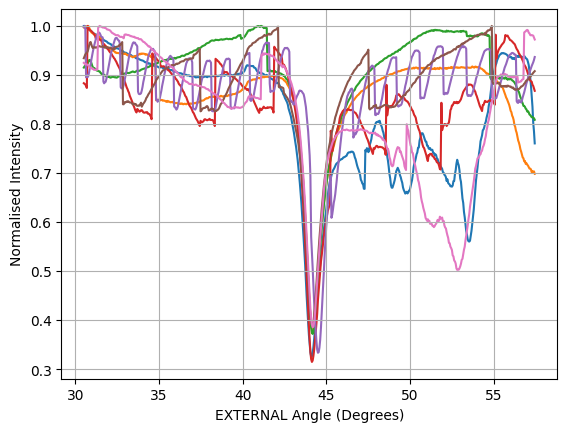

In [241]:
fileListRed = glob("day4_RED/*.txt")

for file in fileListRed:
    PlotFile(file, errors=False)

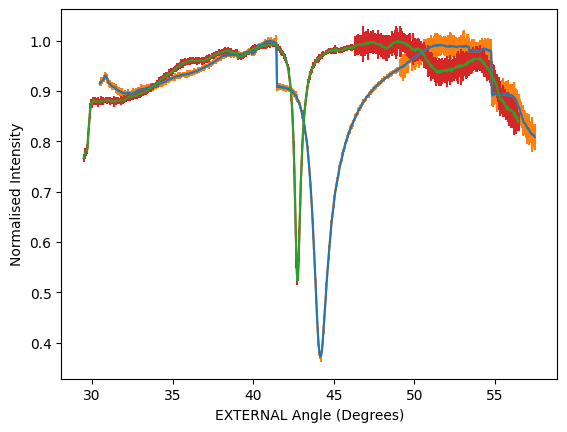

In [294]:
PlotFile("day4_RED/day4Red5.txt", offset=30.5)
PlotFile("13nm/red/red01.txt",offset=29.5)

## Green -> 515 nm

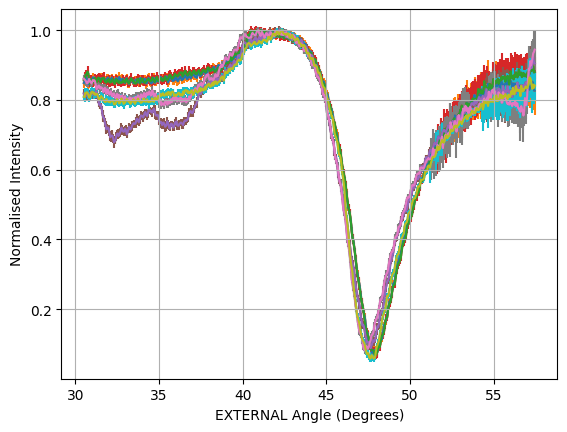

In [265]:
fileListGreen = glob("day4_GREEN/*.txt")

for file in fileListGreen:
    PlotFile(file, errors=True)

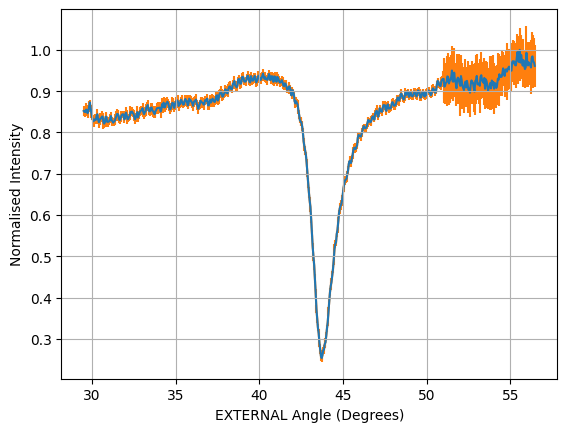

In [204]:
#PlotFile("day4_GREEN/day4Green1.txt", offset=30.5)
PlotFile("13nm/green/green01.txt", offset=29.5)

## Blue -> 405 nm, 43.5 offset1, 43 offset2

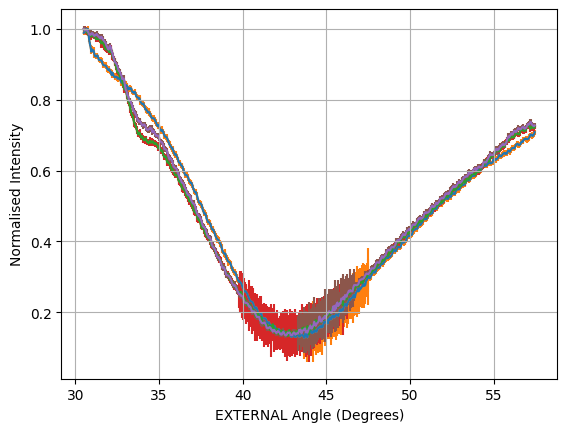

In [267]:
fileListBlue = glob("day4_BLUE/*.txt")

for file in fileListBlue:
    PlotFile(file, errors=True)

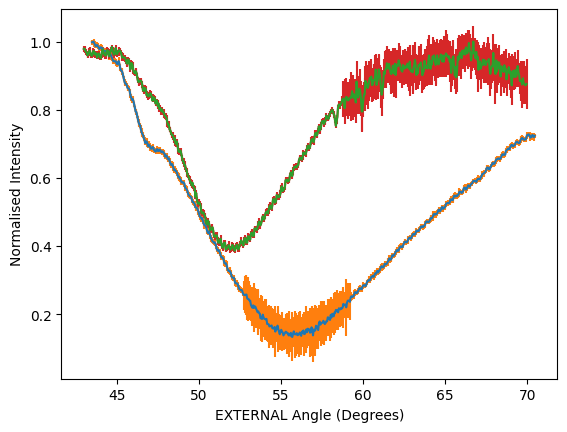

In [295]:
PlotFile("10nm/blue/blue01.txt", offset=43.5)
PlotFile("13nm/blue/blue01.txt", offset=43)

# Period of Oscillations

In [366]:
# Sawtooth wave function

from scipy import signal
from scipy.optimize import curve_fit
from scipy.odr import *

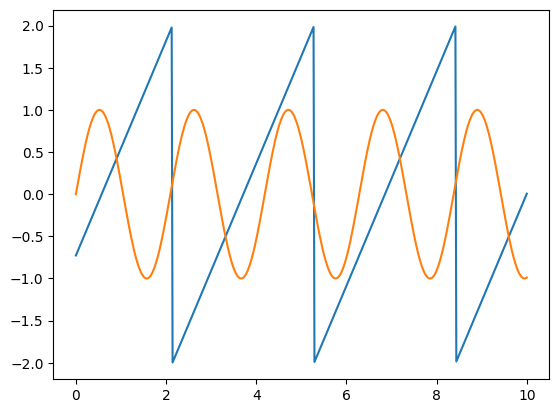

In [290]:
def Sawtooth(t, phi, amp, orientation, height, phase):
    return amp * signal.sawtooth(t / phi + phase, orientation) + height

def Sin(t, amplitude, periodFactor, phase, height):
    return amplitude * np.sin(periodFactor *t + phase) + height

t = np.linspace(0, 10, 500)

plt.plot(t, Sawtooth(t, 0.5, 2, 1, 0, 2))
plt.plot(t, Sin(t, 1, 3, 0, 0))

In [361]:
def FindPeriod(filePath, fitFunction, guessPars, showPlot=False, plotRange=[30.5,37], title=""):
    data = PlotFile(filePath, errors=False, showPlot=False, returnData=True)
    
    if data[:,0][0] == 43.955:
        data = np.flipud(data)
    data = np.delete(data, [np.arange(150,300,1)], 0)

    pars, cov = curve_fit(fitFunction, data[:,0], data[:,1], guessPars)

    t = np.linspace(plotRange[0], plotRange[1], 1000)
    
    period = 2* np.pi / pars[1]

    if showPlot:
        plt.scatter(data[:,0], data[:,1], label="Data", color="indianred", zorder=1)
        plt.plot(t, Sin(t, pars[0], pars[1], pars[2], pars[3]), label=f"Period of Oscillations: {period:0.2f}", color="cornflowerblue", zorder=0)
        plt.title(title)
        #plt.hlines(pars[3], plotRange[0], plotRange[0]+period, color = "orange", label=f"Period {period:0.2f}$^\circ$")
        plt.legend()
        plt.grid()

    uPeriod = np.sqrt(cov[1][1])

    return [period, uPeriod]

In [364]:
periods = list()

timeFiles = glob("Time/dep*.txt")
timeFiles = [str(el) for el in np.sort(timeFiles)]

p0 = FindPeriod(timeFiles[0], Sin, [0.1, 10, 0, 0.9], showPlot=False, title="t = 15:26")
p1 = FindPeriod(timeFiles[1], Sin, [0.1, 5, -1, 0.9], showPlot=False, title="t = 15:30")
p2 = FindPeriod(timeFiles[2], Sin, [0.1, 4, -1, 0.9], showPlot=False, title="t = 15:34")
p3 = FindPeriod(timeFiles[3], Sin, [0.1, 3, -1, 0.9], showPlot=False, title="t = 15:38")
p4 = FindPeriod(timeFiles[4], Sin, [0.1, 2, -1, 0.9], showPlot=False, title="t = 15:42")
p5 = FindPeriod(timeFiles[5], Sin, [0.1, 1/8, -1, 0.9], showPlot=False, title="t = 15:46")
periods = [p0[0], p1[0], p2[0], p3[0], p4[0], p5[0]]
uncertainties = [p0[1], p1[1], p2[1], p3[1], p4[1], p5[1]]
print(periods)
print(uncertainties)

[0.6901732922850106, 1.2384517235201447, 1.7589334464656372, 3.12770424216502, 4.293773651217265, 6.115673636996935]
[0.027316929412567702, 0.02215232417917558, 0.02090828321249266, 0.01944736113510698, 0.01605945950755508, 0.023843644947239433]


[5.28890384e-09 1.87127596e+00]


Text(0, 0.5, 'Period of Oscillations (Degrees)')

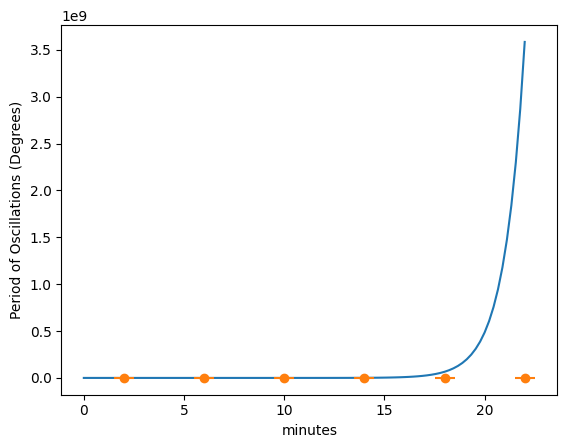

In [388]:
times = [2, 6, 10, 14, 18, 22]
uTime = 0.5 # minutes

def ExpFunc(p, t):
    amp, h = p
    return amp*np.exp(t)+h

expModel = Model(ExpFunc)

data = RealData(times, periods)

odr = ODR(data, expModel, beta0=[1, 10])

out = odr.run()
print(out.beta)
t = np.linspace(0, 22, 100)

#plt.plot(t, ExpFunc(out.beta, t))
plt.plot(t, ExpFunc([1, 0], t))

plt.errorbar(times, periods, xerr=uTime, yerr=uncertainties, fmt="o")
plt.xlabel("minutes")
plt.ylabel("Period of Oscillations (Degrees)")

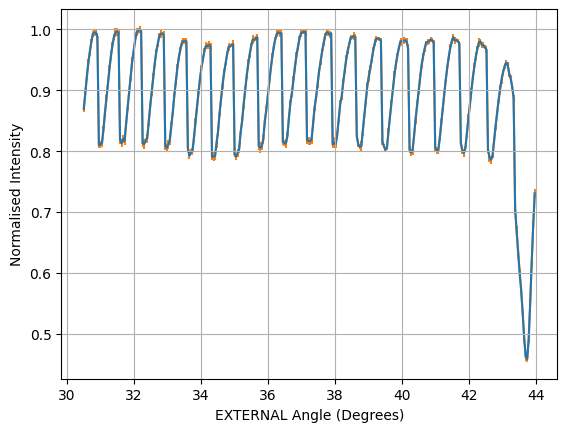

In [371]:
PlotFile("Time/dep1526.txt")

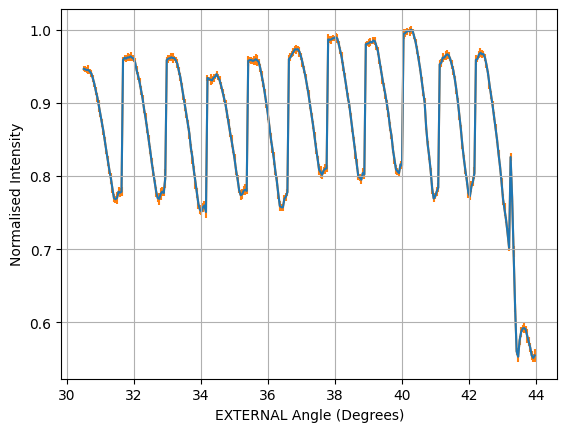

In [194]:
PlotFile("Time/dep1530.txt")

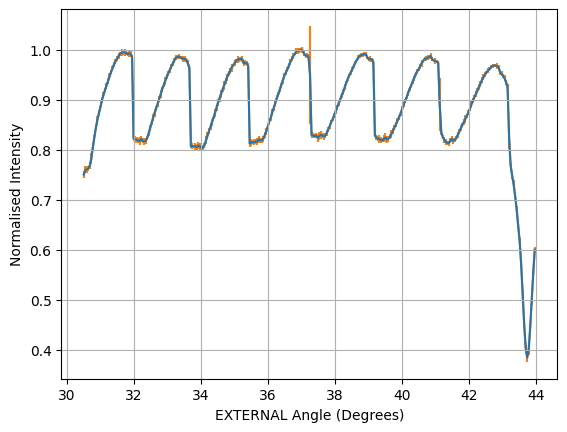

In [195]:
PlotFile("Time/dep1534.txt")

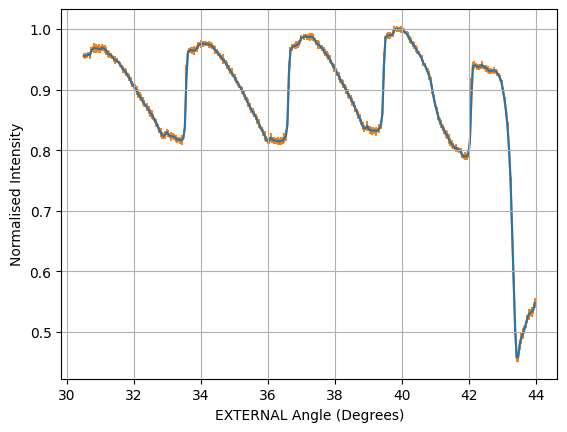

In [196]:
PlotFile("Time/dep1538.txt")

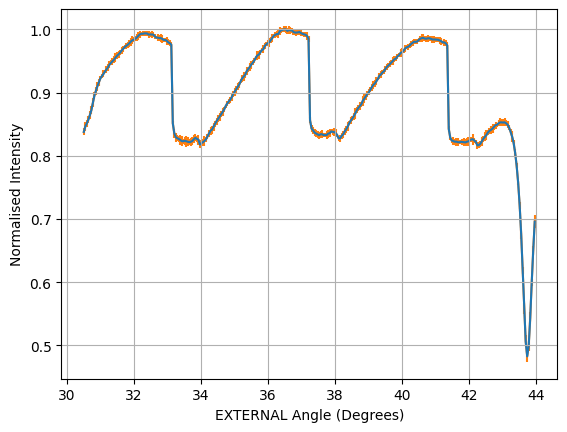

In [197]:
PlotFile("Time/dep1542.txt")

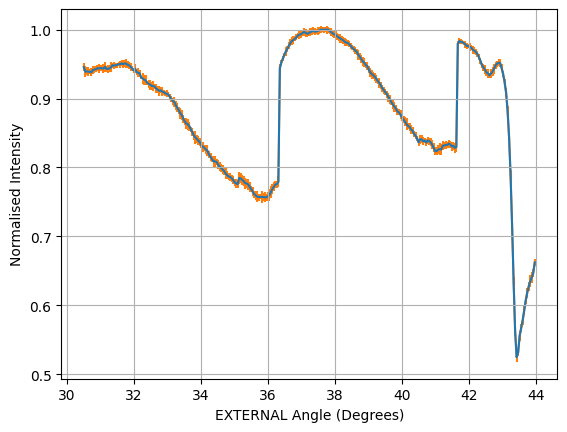

In [198]:
PlotFile("Time/dep1546.txt")

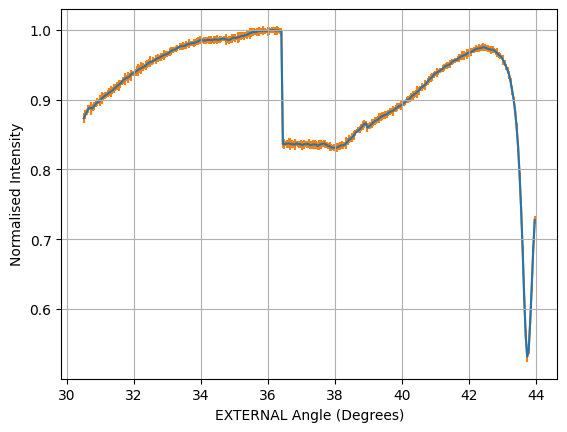

In [199]:
PlotFile("Time/dep1550.txt")

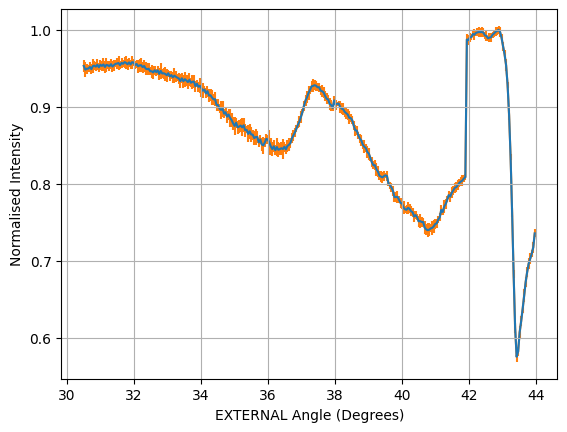

In [200]:
PlotFile("Time/dep1554.txt")

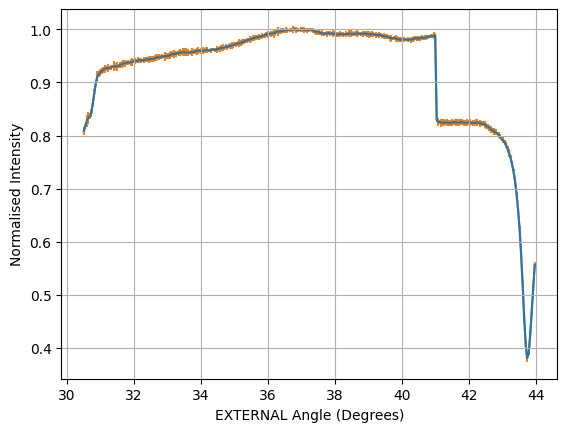

In [201]:
PlotFile("Time/dep1558.txt")

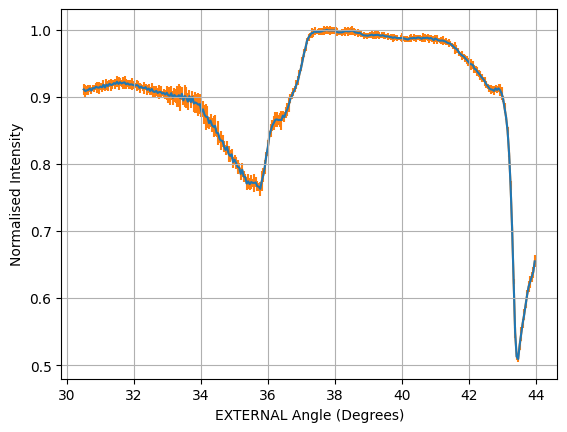

In [202]:
PlotFile("Time/dep1602.txt")

In [203]:
PlotFile("Time/dep1606.txt")

FileNotFoundError: Time/dep1606.txt not found.